In [4]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os
import pandas as pd

from os import environ

environ["OPENCV_IO_ENABLE_JASPER"] = "true"

from scipy import linalg as la
from imageio import imread

import glob
import path
import json

from labelbox import Client
from labelbox import Project
from labelbox import Dataset
from PIL import Image
from io import BytesIO
import pickle
import requests
import logging
import imageio
import os

https://www.fireweatheravalanche.org/fire/

This is a good website to find fires. I found fires on this website, wrote down the coordinates, and then located the fire on a satellite download service like Copernicus. See tutorial on how to download satellite images for more information on the downloading process.

In [5]:
#IMPORTANT
#Replace this line with the path to your satellite TCIs (True Color Images).
#Really just the folder where you have your satellite images, they don't have to be TCIs

#ALSO IMPORTANT
#This code assumes that the folder ONLY HAS satellite images that you intend to use
#It isn't smart enough to distinguish between images and not images, so make sure the folder only has satellite images

path = 'E:\\SatelliteImages\\New_TCIs'

#Adjust this value according to how big you want your resized images to be
new_size = (256,256)

#This value should be true for images with 3 channels (RGB channels) and false for black and white.
#Basically it adjusts the size of the array built to store new images
is_color = True

In [19]:
def resize_images(path, new_size):
    """
    Resize images contained in path folder. 
    
    Parameters:
        path (str): path to folder containg satellite images to be resized.
        new_size (tuple): Tuple of ints, dimensions to resize image to
    
    Output:
        Resized folder containing resized images
    """
    os.chdir(path)

    path_parent = os.path.dirname(os.getcwd())
    if not os.path.exists(os.path.join(path_parent, 'Resized')):
        os.makedirs(os.path.join(path_parent, 'Resized'))
        print("Created folder 'Resized' for resized images!")
    resized_path = os.path.join(path_parent, 'Resized')

    images = os.listdir()
    for i in images:
        os.chdir(path)
        img = cv2.imread(i)
        resized = cv2.resize(img, new_size, interpolation = cv2.INTER_AREA)

        filename = i.split(".")[0] + '_Resized.png'
        os.chdir(resized_path)

        os.chdir('E:\\SatelliteImages\\New_Resized')
        cv2.imwrite(filename, resized)

There is some user work required between these two cells. The above cell resizes original images into a more managable shape to be able to reasonably load into python and other places. 

The below cell downloads images and labels from LabelBox. 

The user work required is to go on to LabelBox, create a project, upload the newly resized images, and hand-draw a label for each one. Then simply follow the instructions on the website for exporting. Those instructions will contain a project_id and give instructions for how to obtain an API key. Paste both of those below and simply run the code. I have left my project_id below to allow people to download my images and labels if desired. 

In [ ]:
#Uncomment out the line below if you don't have the labelbox library installed
#!pip install labelbox

import labelbox

In [4]:
masks = {}
project_id = 'ckxeye79osbh30z8q5mw3gkoz'
API_KEY = YOUR_API_KEY_HERE


LB_API_KEY = API_KEY
# Create Labelbox client
lb = labelbox.Client(api_key=LB_API_KEY)
# Get project by ID
project = lb.get_project(project_id)

# Export labels as a json:
lbl = project.export_labels(download = True)


for lbl_dict in lbl:

    if 'objects' not in list(lbl_dict['Label'].keys()) or len(lbl_dict['Label']['objects']) == 0:
        print("Empty")
        pass
    

    else:
        name = lbl_dict['External ID'][:-12]
        #masks[name] = {}
        
        for mask in lbl_dict['Label']['objects']:

            # Get mask type
            type_ = mask['value']

            # Try and download mask image
            try:
                m = Image.open(BytesIO(requests.get(mask['instanceURI']).content))
                m = np.asarray(m)[:,:,-1].copy()
                print("I downloaded a label!")
            except:
                print("Didn't work...")
            
            #Allows for multiple masks on the same image
            #This means that you can add two or more fires on the same image
            if name in list(masks.keys()):
                masks[name]['mask'] += m
            else:
                masks[name] = {'mask':m}

    

I downloaded stuff
I downloaded stuff
I downloaded stuff
I downloaded stuff


In [7]:
#Get names for images to read
image_names = list(masks.keys())

#Create empty arrays for labels and images
label_array = np.zeros((len(image_names),*new_size))

if is_color:
    image_array = np.zeros((len(image_names),*new_size,3))
else:
    image_array = np.zeros((len(image_names),*new_size))
    
#Change directory to folder containing resized images
os.chdir(path)
path_parent = os.path.dirname(os.getcwd())
os.chdir(os.path.join(path_parent, 'Resized'))

#Get images and labels and pass them to respective spots in arrays
for i, name in enumerate(image_names):
    label_array[i] = masks[name]['mask']
    image_array[i] = imread(name + '_Resized.png')

#Change images from floats to ints
image_array = image_array.astype(int)

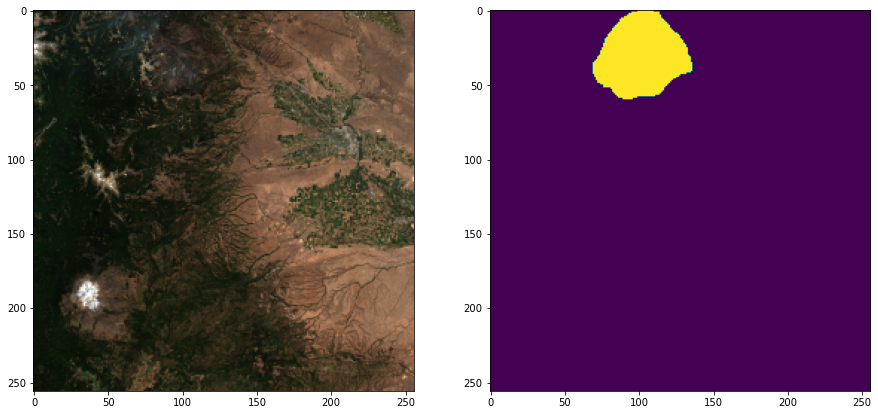

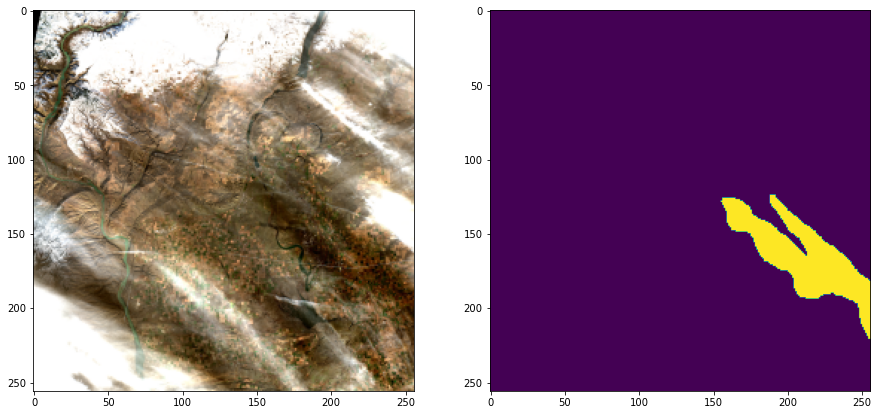

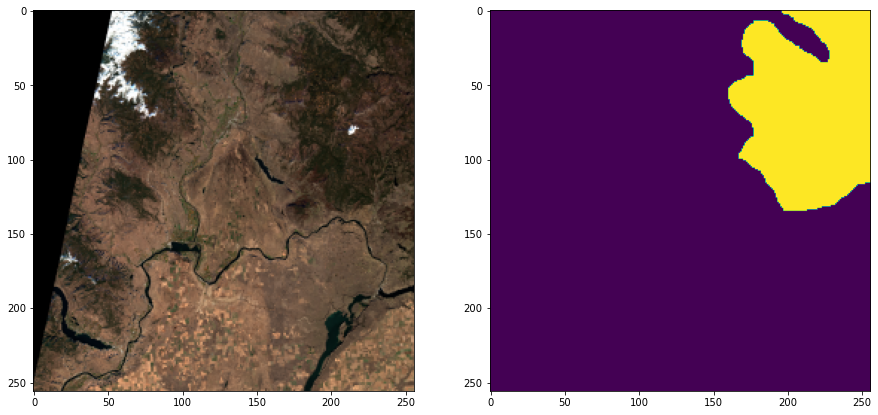

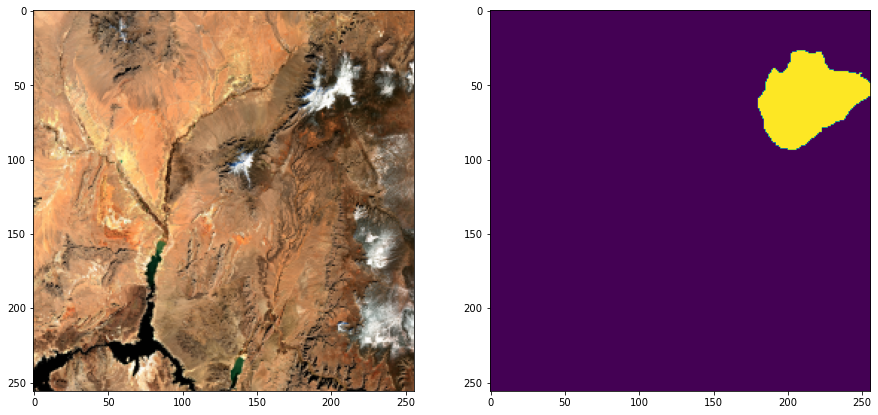

In [8]:
#Plot first four images with corresponding label for quality control purposes
for i in range(4):
    fig,ax = plt.subplots(1,2,figsize=(15,15))
    ax[0].imshow(image_array[i])
    ax[1].imshow(label_array[i])
    plt.show()

In [9]:
os.chdir(path)
os.chdir(os.path.dirname(os.getcwd()))

#Adjust names of images and labels files as desired
np.save('images.npy', image_array)
np.save('labels.npy', label_array)